<a href="https://colab.research.google.com/github/AndreasAvgou/Liver-Disease-Prediction/blob/main/Liver_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import xgboost as xgb
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,classification_report


from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Liver Disease Prediction/train_dataset.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Liver Disease Prediction/test_dataset.csv")
train_df.head(15)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0
3,3135,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.3,302.0,2.02,49.0,NaN,26.35,NaN,NaN,10.5,4.0
4,2483,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.5,344.0,3.11,91.0,NaN,104.56,NaN,306.0,11.4,2.0
5,2306,1255,C,Placebo,14353,F,Y,N,N,N,9.9,NaN,3.57,4.0,462.6,103.40,126.0,276.0,12.1,4.0
6,2525,2065,C,NaN,25357,F,N,Y,NaN,N,0.3,NaN,2.60,103.0,NaN,NaN,200.0,365.0,10.5,4.0
7,6908,1118,D,Placebo,28620,F,NaN,NaN,N,N,2.0,357.0,3.11,94.0,3403.8,NaN,NaN,254.0,10.1,4.0
8,8388,4313,D,NaN,24638,F,N,N,NaN,N,1.2,NaN,3.51,67.0,1850.6,44.21,NaN,434.0,11.1,2.0
9,9132,3240,D,NaN,13860,F,N,N,NaN,N,8.7,NaN,3.02,NaN,NaN,87.62,NaN,102.0,11.2,3.0


In [ ]:
print("============= TRAIN SET =============")
print("Missing Values: " ,np.sum(train_df.isnull().any(axis=1)))
print("Shape: ", train_df.shape)
print("Columns: ", len(train_df.columns))
print("Data types:")
print(train_df.dtypes)
print("============= TEST SET =============")
print("Missing Values: ",(np.sum(test_df.isnull().any(axis=1))))
print("Shape: ", test_df.shape)
print("Columns: ", len(test_df.columns))
print("Data types:")
print(test_df.dtypes)

============= TRAIN SET =============
Missing Values:  6685
Shape:  (6800, 20)
Columns:  20
Data types:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object
============= TEST SET =============
Missing Values:  3136
Shape:  (3200, 19)
Columns:  19
Data types:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Chol

In [ ]:
train_df.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False
4,False,False,False,False,False,False,True,True,True,False,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
6796,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False
6797,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False
6798,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
test_df.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False
4,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False
3196,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3197,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
3198,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_df.describe()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,6800.000000,6800.000000,6800.000000,6800.000000,3699.000000,6800.000000,4644.000000,4302.000000,4698.000000,3988.000000,6462.000000,6645.000000,6800.000000
mean,6268.608088,1664.055441,22863.223529,1.806147,294.575831,3.036118,68.569121,1802.951464,79.554427,133.857823,293.306097,11.231031,3.157206
std,2405.527133,1332.308135,4671.135682,3.218009,128.085317,0.528164,59.637733,1618.550339,43.433832,47.291444,115.146088,1.123444,0.993059
min,1239.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,4353.750000,537.000000,19416.500000,0.300000,204.000000,2.680000,26.000000,1122.650000,35.290000,114.000000,213.000000,10.500000,2.000000
50%,6599.500000,1443.000000,23367.000000,0.400000,312.000000,3.020000,68.000000,1563.150000,88.505000,128.000000,285.000000,11.100000,4.000000
75%,8299.250000,2519.000000,27125.500000,1.800000,353.000000,3.390000,91.000000,2013.250000,110.672500,141.000000,365.000000,11.700000,4.000000
max,9999.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,340.480000,498.000000,563.000000,18.000000,4.000000


In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             6800 non-null   int64  
 1   N_Days         6800 non-null   int64  
 2   Status         6800 non-null   object 
 3   Drug           4775 non-null   object 
 4   Age            6800 non-null   int64  
 5   Sex            6800 non-null   object 
 6   Ascites        4554 non-null   object 
 7   Hepatomegaly   4373 non-null   object 
 8   Spiders        4210 non-null   object 
 9   Edema          6800 non-null   object 
 10  Bilirubin      6800 non-null   float64
 11  Cholesterol    3699 non-null   float64
 12  Albumin        6800 non-null   float64
 13  Copper         4644 non-null   float64
 14  Alk_Phos       4302 non-null   float64
 15  SGOT           4698 non-null   float64
 16  Tryglicerides  3988 non-null   float64
 17  Platelets      6462 non-null   float64
 18  Prothrom

In [ ]:
train_df['Stage'].value_counts()

4.0    3506
2.0    1507
3.0    1322
1.0     465
Name: Stage, dtype: int64

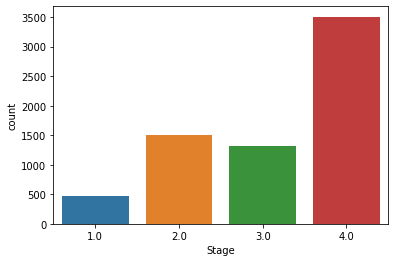

In [ ]:
sns.countplot(train_df['Stage'])

In [ ]:
df1 = train_df.fillna(method = 'bfill')
df2 = test_df.fillna(method = 'bfill')
#df1 = train_df.dropna()
#df2 = test_df.dropna()

In [ ]:
df1.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6796,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6797,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6798,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
df2.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3196,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3197,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3198,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             6800 non-null   int64  
 1   N_Days         6800 non-null   int64  
 2   Status         6800 non-null   object 
 3   Drug           6800 non-null   object 
 4   Age            6800 non-null   int64  
 5   Sex            6800 non-null   object 
 6   Ascites        6800 non-null   object 
 7   Hepatomegaly   6800 non-null   object 
 8   Spiders        6799 non-null   object 
 9   Edema          6800 non-null   object 
 10  Bilirubin      6800 non-null   float64
 11  Cholesterol    6798 non-null   float64
 12  Albumin        6800 non-null   float64
 13  Copper         6799 non-null   float64
 14  Alk_Phos       6799 non-null   float64
 15  SGOT           6800 non-null   float64
 16  Tryglicerides  6800 non-null   float64
 17  Platelets      6800 non-null   float64
 18  Prothrom

In [ ]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             3200 non-null   int64  
 1   N_Days         3200 non-null   int64  
 2   Status         3200 non-null   object 
 3   Drug           3200 non-null   object 
 4   Age            3200 non-null   int64  
 5   Sex            3200 non-null   object 
 6   Ascites        3200 non-null   object 
 7   Hepatomegaly   3200 non-null   object 
 8   Spiders        3200 non-null   object 
 9   Edema          3200 non-null   object 
 10  Bilirubin      3200 non-null   float64
 11  Cholesterol    3199 non-null   float64
 12  Albumin        3200 non-null   float64
 13  Copper         3200 non-null   float64
 14  Alk_Phos       3200 non-null   float64
 15  SGOT           3199 non-null   float64
 16  Tryglicerides  3200 non-null   float64
 17  Platelets      3200 non-null   float64
 18  Prothrom

In [ ]:
df1.shape



(6800, 20)

In [ ]:
df2.shape

(3200, 19)

In [ ]:
df1

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,C,D-penicillamine,22880,F,N,N,Y,N,0.3,328.0,2.96,4.0,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,D,D-penicillamine,27957,F,N,N,Y,N,0.3,328.0,2.64,4.0,462.6,26.35,116.0,194.0,10.3,3.0
3,3135,1872,C,D-penicillamine,21111,F,Y,Y,Y,N,0.3,302.0,2.02,49.0,462.6,26.35,126.0,306.0,10.5,4.0
4,2483,939,CL,D-penicillamine,18061,F,Y,N,N,N,0.5,344.0,3.11,91.0,462.6,104.56,126.0,306.0,11.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,4622,1762,C,Placebo,20909,M,Y,N,N,N,0.9,360.0,2.43,43.0,3444.4,131.59,130.0,314.0,12.9,1.0
6796,4446,2955,C,Placebo,28650,F,Y,N,N,N,0.3,218.0,2.99,43.0,289.0,26.35,238.0,399.0,10.6,4.0
6797,4082,584,C,D-penicillamine,24102,F,N,Y,Y,N,0.3,218.0,2.79,12.0,289.0,26.35,123.0,103.0,9.3,1.0
6798,2248,1426,CL,D-penicillamine,19791,F,N,N,Y,N,0.3,NaN,1.96,12.0,289.0,72.95,134.0,354.0,10.6,2.0


In [ ]:
df2

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,3870,41,C,Placebo,22553,F,N,Y,N,N,1.4,247.0,3.62,92.0,1748.1,108.65,129.0,169.0,11.6
1,3462,1811,C,D-penicillamine,16223,F,N,Y,N,N,0.3,311.0,2.80,92.0,1748.1,43.52,129.0,321.0,11.5
2,1632,954,C,D-penicillamine,27100,F,N,N,N,N,0.4,206.0,3.56,89.0,617.1,43.52,129.0,296.0,10.3
3,722,1969,D,Placebo,17039,F,N,Y,N,N,1.2,206.0,3.16,89.0,617.1,113.76,129.0,125.0,10.9
4,1000,2721,D,D-penicillamine,17738,F,N,N,N,N,3.2,206.0,2.36,89.0,1782.4,37.87,129.0,138.0,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2601,4513,D,Placebo,18293,M,N,N,N,S,0.3,422.0,2.75,106.0,2063.9,111.68,166.0,563.0,10.9
3196,53,3281,D,D-penicillamine,12149,F,N,N,Y,N,4.7,422.0,4.30,106.0,1203.2,32.49,166.0,234.0,10.2
3197,386,1933,D,D-penicillamine,17084,F,N,Y,N,N,0.8,408.0,3.56,9.0,2358.1,124.70,131.0,234.0,11.6
3198,920,2350,D,Placebo,28650,M,N,N,N,Y,15.3,258.0,3.21,32.0,1472.7,113.24,130.0,110.0,10.3


In [ ]:
print("============= TRAIN SET =============")
print("Missing Values: " ,np.sum(df1.isnull().any(axis=1)))
print("Shape: ", df1.shape)
print("Columns: ", len(df1.columns))
print("Data types:")
print(df1.dtypes)
print("============= TEST SET =============")
print("Missing Values: ",(np.sum(df2.isnull().any(axis=1))))
print("Shape: ", df2.shape)
print("Columns: ", len(df2.columns))
print("Data types:")
print(df2.dtypes)

============= TRAIN SET =============
Missing Values:  2
Shape:  (6800, 20)
Columns:  20
Data types:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object
============= TEST SET =============
Missing Values:  1
Shape:  (3200, 19)
Columns:  19
Data types:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholestero

In [ ]:
le = LabelEncoder()
dfle1 = df1
dfle2 = df2

In [ ]:
dfle1.Status = le.fit_transform(dfle1.Status)
dfle1.Drug = le.fit_transform(dfle1.Drug)
dfle1.Sex = le.fit_transform(dfle1.Sex)
dfle1.Ascites = le.fit_transform(dfle1.Ascites)
dfle1.Hepatomegaly = le.fit_transform(dfle1.Hepatomegaly)
dfle1.Spiders = le.fit_transform(dfle1.Spiders)
dfle1.Edema = le.fit_transform(dfle1.Edema)

In [ ]:
dfle2.Status = le.fit_transform(dfle2.Status)
dfle2.Drug = le.fit_transform(dfle2.Drug)
dfle2.Sex = le.fit_transform(dfle2.Sex)
dfle2.Ascites = le.fit_transform(dfle2.Ascites)
dfle2.Hepatomegaly = le.fit_transform(dfle2.Hepatomegaly)
dfle2.Spiders = le.fit_transform(dfle2.Spiders)
dfle2.Edema = le.fit_transform(dfle2.Edema)

In [ ]:
dfle1.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6796,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6797,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6798,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
dfle2.isnull()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3196,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3197,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3198,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
dfle1 = dfle1.dropna()
dfle2 = dfle2.dropna()


In [ ]:
dfle1

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,1,0,19581,0,0,0,1,0,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,0,0,22880,0,0,0,1,0,0.3,328.0,2.96,4.0,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,2,0,27957,0,0,0,1,0,0.3,328.0,2.64,4.0,462.6,26.35,116.0,194.0,10.3,3.0
3,3135,1872,0,0,21111,0,1,1,1,0,0.3,302.0,2.02,49.0,462.6,26.35,126.0,306.0,10.5,4.0
4,2483,939,1,0,18061,0,1,0,0,0,0.5,344.0,3.11,91.0,462.6,104.56,126.0,306.0,11.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,2152,3353,0,0,21290,0,0,0,1,1,0.3,442.0,2.29,274.0,1741.9,111.85,173.0,270.0,11.0,4.0
6794,9238,41,2,0,19969,0,0,0,0,2,5.9,442.0,3.15,43.0,1966.0,103.10,117.0,98.0,10.1,3.0
6795,4622,1762,0,1,20909,1,1,0,0,0,0.9,360.0,2.43,43.0,3444.4,131.59,130.0,314.0,12.9,1.0
6796,4446,2955,0,1,28650,0,1,0,0,0,0.3,218.0,2.99,43.0,289.0,26.35,238.0,399.0,10.6,4.0


In [ ]:
dfle2

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,3870,41,0,1,22553,0,0,1,0,0,1.4,247.0,3.62,92.0,1748.1,108.65,129.0,169.0,11.6
1,3462,1811,0,0,16223,0,0,1,0,0,0.3,311.0,2.80,92.0,1748.1,43.52,129.0,321.0,11.5
2,1632,954,0,0,27100,0,0,0,0,0,0.4,206.0,3.56,89.0,617.1,43.52,129.0,296.0,10.3
3,722,1969,2,1,17039,0,0,1,0,0,1.2,206.0,3.16,89.0,617.1,113.76,129.0,125.0,10.9
4,1000,2721,2,0,17738,0,0,0,0,0,3.2,206.0,2.36,89.0,1782.4,37.87,129.0,138.0,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,4118,4324,0,0,18692,0,1,0,0,0,0.3,120.0,2.21,47.0,1805.0,111.68,166.0,207.0,9.7
3195,2601,4513,2,1,18293,1,0,0,0,1,0.3,422.0,2.75,106.0,2063.9,111.68,166.0,563.0,10.9
3196,53,3281,2,0,12149,0,0,0,1,0,4.7,422.0,4.30,106.0,1203.2,32.49,166.0,234.0,10.2
3197,386,1933,2,0,17084,0,0,1,0,0,0.8,408.0,3.56,9.0,2358.1,124.70,131.0,234.0,11.6


In [ ]:
dfle1['Age'] = dfle1['Age'] / 365
dfle2['Age'] = dfle2['Age'] / 365

In [ ]:
dfle1['Age']= dfle1['Age'].astype('int64')
dfle1['Bilirubin']= dfle1['Bilirubin'].astype('int64')
dfle1['Cholesterol']= dfle1['Cholesterol'].astype('int64')
dfle1['Albumin']= dfle1['Albumin'].astype('int64')
dfle1['Copper']= dfle1['Copper'].astype('int64')
dfle1['Alk_Phos']= dfle1['Alk_Phos'].astype('int64')
dfle1['SGOT']= dfle1['SGOT'].astype('int64')
dfle1['Tryglicerides']= dfle1['Tryglicerides'].astype('int64')
dfle1['Platelets']= dfle1['Platelets'].astype('int64')
dfle1['Prothrombin']= dfle1['Prothrombin'].astype('int64')
dfle1['Prothrombin']= dfle1['Prothrombin'].astype('int64')


dfle2['Age']= dfle2['Age'].astype('int64')
dfle2['Bilirubin']= dfle2['Bilirubin'].astype('int64')
dfle2['Cholesterol']= dfle2['Cholesterol'].astype('int64')
dfle2['Albumin']= dfle2['Albumin'].astype('int64')
dfle2['Copper']= dfle2['Copper'].astype('int64')
dfle2['Alk_Phos']= dfle2['Alk_Phos'].astype('int64')
dfle2['SGOT']= dfle2['SGOT'].astype('int64')
dfle2['Tryglicerides']= dfle2['Tryglicerides'].astype('int64')
dfle2['Platelets']= dfle2['Platelets'].astype('int64')
dfle2['Prothrombin']= dfle2['Prothrombin'].astype('int64')
dfle2['Prothrombin']= dfle2['Prothrombin'].astype('int64')

In [ ]:
dfle1

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,1,0,53,0,0,0,1,0,0,279,2,84,1500,99,109,293,10,4.0
1,7326,41,0,0,62,0,0,0,1,0,0,328,2,4,1835,26,131,308,10,1.0
2,7254,297,2,0,76,0,0,0,1,0,0,328,2,4,462,26,116,194,10,3.0
3,3135,1872,0,0,57,0,1,1,1,0,0,302,2,49,462,26,126,306,10,4.0
4,2483,939,1,0,49,0,1,0,0,0,0,344,3,91,462,104,126,306,11,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6793,2152,3353,0,0,58,0,0,0,1,1,0,442,2,274,1741,111,173,270,11,4.0
6794,9238,41,2,0,54,0,0,0,0,2,5,442,3,43,1966,103,117,98,10,3.0
6795,4622,1762,0,1,57,1,1,0,0,0,0,360,2,43,3444,131,130,314,12,1.0
6796,4446,2955,0,1,78,0,1,0,0,0,0,218,2,43,289,26,238,399,10,4.0


In [ ]:
dfle2

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,3870,41,0,1,61,0,0,1,0,0,1,247,3,92,1748,108,129,169,11
1,3462,1811,0,0,44,0,0,1,0,0,0,311,2,92,1748,43,129,321,11
2,1632,954,0,0,74,0,0,0,0,0,0,206,3,89,617,43,129,296,10
3,722,1969,2,1,46,0,0,1,0,0,1,206,3,89,617,113,129,125,10
4,1000,2721,2,0,48,0,0,0,0,0,3,206,2,89,1782,37,129,138,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,4118,4324,0,0,51,0,1,0,0,0,0,120,2,47,1805,111,166,207,9
3195,2601,4513,2,1,50,1,0,0,0,1,0,422,2,106,2063,111,166,563,10
3196,53,3281,2,0,33,0,0,0,1,0,4,422,4,106,1203,32,166,234,10
3197,386,1933,2,0,46,0,0,1,0,0,0,408,3,9,2358,124,131,234,11


In [ ]:
dfle1.describe()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000
mean,6269.411739,1664.316858,0.849220,0.481759,62.144160,0.141954,0.124743,0.412033,0.310091,0.283172,1.418947,295.381877,2.521183,68.789056,1826.327155,78.716976,133.217417,293.661224,10.773610,3.157252
std,2405.322919,1332.370209,0.947842,0.499704,12.802128,0.349028,0.330451,0.492237,0.462565,0.579414,3.195527,124.663266,0.639356,60.109658,1665.707301,43.251409,46.278272,114.959122,1.151122,0.993054
min,1239.000000,41.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,1.000000,4.000000,289.000000,26.000000,33.000000,62.000000,9.000000,1.000000
25%,4354.500000,537.250000,0.000000,0.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,2.000000,26.000000,1131.000000,35.000000,114.000000,214.250000,10.000000,2.000000
50%,6600.500000,1443.500000,0.000000,0.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,314.000000,3.000000,68.000000,1563.500000,86.000000,128.000000,285.000000,11.000000,4.000000
75%,8299.750000,2519.000000,2.000000,1.000000,74.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,355.000000,3.000000,91.000000,2013.750000,110.000000,141.000000,365.000000,11.000000,4.000000
max,9999.000000,4795.000000,2.000000,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,2.000000,28.000000,1775.000000,4.000000,588.000000,13862.000000,340.000000,498.000000,563.000000,18.000000,4.000000


In [ ]:
print("============= TRAIN SET =============")
print("Missing Values: " ,np.sum(dfle1.isnull().any(axis=1)))
print("Shape: ", dfle1.shape)
print("Columns: ", len(dfle1.columns))
print("Data types:")
print(dfle1.dtypes)
print("============= TEST SET =============")
print("Missing Values: ",(np.sum(dfle2.isnull().any(axis=1))))
print("Shape: ", dfle2.shape)
print("Columns: ", len(dfle2.columns))
print("Data types:")
print(dfle2.dtypes)

============= TRAIN SET =============
Missing Values:  0
Shape:  (6798, 20)
Columns:  20
Data types:
ID                 int64
N_Days             int64
Status             int64
Drug               int64
Age                int64
Sex                int64
Ascites            int64
Hepatomegaly       int64
Spiders            int64
Edema              int64
Bilirubin          int64
Cholesterol        int64
Albumin            int64
Copper             int64
Alk_Phos           int64
SGOT               int64
Tryglicerides      int64
Platelets          int64
Prothrombin        int64
Stage            float64
dtype: object
============= TEST SET =============
Missing Values:  0
Shape:  (3199, 19)
Columns:  19
Data types:
ID               int64
N_Days           int64
Status           int64
Drug             int64
Age              int64
Sex              int64
Ascites          int64
Hepatomegaly     int64
Spiders          int64
Edema            int64
Bilirubin        int64
Cholesterol      int64
Albumin  

In [ ]:
X = dfle1.drop(['Stage'], axis=1)
y = dfle1['Stage']

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
X_resampled.shape


(1860, 19)

In [ ]:
percent_missing = round((dfle1.isnull().mean() * 100),2)

In [ ]:
missing_value_df = pd.DataFrame({'column_name': dfle1.columns,
                                 'percent_missing': percent_missing})

In [ ]:
missing_value_df

,column_name,percent_missing
ID,ID,0.0
N_Days,N_Days,0.0
Status,Status,0.0
Drug,Drug,0.0
Age,Age,0.0
Sex,Sex,0.0
Ascites,Ascites,0.0
Hepatomegaly,Hepatomegaly,0.0
Spiders,Spiders,0.0
Edema,Edema,0.0


In [ ]:
X.head()
X.columns

Index(['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites',
       'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
       'Prothrombin'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)


In [ ]:
X_train.shape


(1395, 19)

In [ ]:
xgb_params = {
'objective': 'reg:squarederror',
'n_estimators': 3300,
'max_depth': 4,
'learning_rate': 0.25,
'booster': 'gbtree',
'n_jobs': -1,
}

In [ ]:
xgb_model = xgb.XGBClassifier(**xgb_params)


In [ ]:
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
#clasf = DecisionTreeClassifier(random_state=8)

In [ ]:
xgb_model.fit(X_train,y_train)


XGBClassifier(learning_rate=0.25, max_depth=4, n_estimators=3300, n_jobs=-1,
              objective='multi:softprob')

In [ ]:
print(X_train.shape,y_train.shape)


(1395, 19) (1395,)


In [ ]:
# Predicting that on X_test
pred = xgb_model.predict(X_test)
pred

array([3., 1., 4., 4., 2., 3., 3., 2., 1., 1., 2., 3., 1., 3., 3., 4., 3.,
       3., 4., 1., 3., 3., 2., 1., 3., 1., 4., 4., 2., 3., 4., 4., 3., 3.,
       4., 4., 2., 1., 2., 4., 1., 2., 1., 4., 3., 3., 2., 3., 3., 3., 1.,
       1., 3., 4., 4., 1., 1., 2., 1., 1., 1., 1., 1., 3., 4., 4., 3., 2.,
       2., 3., 3., 1., 4., 2., 3., 3., 3., 2., 4., 2., 2., 1., 3., 2., 4.,
       4., 2., 4., 3., 1., 4., 4., 3., 2., 2., 3., 3., 4., 4., 4., 3., 3.,
       1., 1., 4., 3., 3., 3., 2., 3., 4., 1., 4., 4., 3., 1., 3., 1., 3.,
       4., 2., 3., 1., 1., 3., 1., 3., 1., 2., 4., 4., 1., 1., 1., 4., 2.,
       3., 3., 2., 3., 3., 2., 3., 1., 2., 2., 4., 3., 4., 3., 1., 3., 1.,
       3., 1., 3., 3., 3., 1., 3., 1., 2., 3., 2., 4., 4., 1., 1., 4., 1.,
       4., 4., 2., 3., 1., 4., 2., 2., 3., 4., 2., 4., 3., 1., 3., 3., 4.,
       3., 2., 1., 3., 3., 4., 3., 1., 1., 4., 4., 2., 4., 3., 1., 1., 4.,
       3., 1., 1., 2., 3., 4., 3., 2., 3., 2., 4., 3., 1., 1., 2., 1., 1.,
       4., 2., 2., 3., 2.

In [ ]:
y_preds = xgb_model.predict(X_test)
# Rounding it of
y_preds = np.round(y_preds)
print('Accuracy Score is: ', accuracy_score(y_test, y_preds))

Accuracy Score is:  0.35698924731182796


In [ ]:
cm = confusion_matrix(y_true=y_test,y_pred=y_preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_true=(y_test),y_pred=(y_preds)))

              precision    recall  f1-score   support

         1.0       0.25      0.23      0.24       108
         2.0       0.32      0.29      0.30       115
         3.0       0.39      0.46      0.42       120
         4.0       0.43      0.43      0.43       122

    accuracy                           0.36       465
   macro avg       0.35      0.35      0.35       465
weighted avg       0.35      0.36      0.35       465

